In [1]:
! pip install torch tqdm
#! pip install --upgrade git+https://github.com/rimgro/biocadprotein.git

You should consider upgrading via the 'C:\Users\User\Desktop\biocadprotein\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [19]:
torch.manual_seed(12)
np.random.seed(12)

<h3>Подготовка данных</h3>

In [ ]:
from fpgen.prop_prediction.dataset import FPbase
from fpgen.prop_prediction.metrics import get_regression_metrics

from fpgen.prop_prediction.models.embedding_cnn import EmbeddingCNN
from fpgen.prop_prediction.models.embedding_lstm import EmbeddingLSTM
from fpgen.prop_prediction.models.sequence_cnn import SequenceCNN
from fpgen.prop_prediction.models.sequence_lstm import SequenceLSTM

from torch.utils.data import TensorDataset, DataLoader

In [21]:
dataset = FPbase('data/fpbase.csv')

# one-hot encoding setup
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
vocab = {aa: i for i, aa in enumerate(amino_acids)}

In [22]:
x_train, y_train = dataset.get_train('em_max')
from sklearn.model_selection import train_test_split

# Split training data into train and validation sets (e.g., 80% train, 20% val)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

x_test, y_test = dataset.get_test('em_max')

In [23]:
def encode_sequences(sequences, vocab, max_length=None):
    """
    One-hot encode protein sequences
    
    Args:
        sequences: List of protein sequences (strings)
        vocab: Amino acid vocabulary dictionary (only used for consistency)
        max_length: Maximum sequence length (will pad/truncate)
    
    Returns:
        One-hot encoded sequences as torch tensor of shape (num_sequences, max_length, 20)
    """
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)
    
    # Standard 20 amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
    
    encoded = []
    for seq in sequences:
        # Initialize one-hot matrix for this sequence
        seq_onehot = torch.zeros(max_length, 20)
        
        # Convert to uppercase and encode each amino acid
        seq_upper = seq.upper()
        for i, aa in enumerate(seq_upper):
            if i >= max_length:
                break
            if aa in aa_to_idx:
                seq_onehot[i, aa_to_idx[aa]] = 1.0
            # If amino acid is not in standard 20, leave as zeros (unknown)
        
        encoded.append(seq_onehot)
    
    return torch.stack(encoded)

<h3>Преобразование в one-hot encoding</h3>

In [24]:
x_train_encoded = encode_sequences(x_train, vocab, max_length=256)
x_val_encoded = encode_sequences(x_val, vocab, max_length=256)
x_test_encoded = encode_sequences(x_test, vocab, max_length=256)
x_train_encoded.shape

torch.Size([514, 256, 20])

In [25]:
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [26]:
dataset_train = TensorDataset(x_train_encoded, y_train_tensor)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
    
dataset_val = TensorDataset(x_val_encoded, y_val_tensor)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
    
dataset_test = TensorDataset(x_test_encoded, y_test_tensor)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# Доготовка данных для работы с embeddings ESM C

In [27]:
import pickle

with open('sequence.pickle', 'rb') as file:
    seq = pickle.load(file)

In [28]:
seq[x_train.iloc[0]].shape

torch.Size([1, 236, 960])

In [29]:
def preprocessing_x(x_tr, x_t, x_v, seq, pad_value=0.0, max_length=None):
    """
    Improved preprocessing function for LSTM training with ESM embeddings
    
    Args:
        x_tr, x_t, x_v: Index arrays for train, test, val
        seq: Dictionary/list containing the embeddings
        pad_value: Value to use for padding (default: 0.0)
        max_length: Maximum sequence length (if None, computed from data)
    """
    
    def get_cleaned_tensors(indexes):
        cleaned = []
        for i in range(len(indexes)):
            tensor = seq[indexes.iloc[i]]  # shape: [1, L, D]
            
            # Handle different input shapes
            if tensor.dim() == 3 and tensor.shape[0] == 1:
                tensor = tensor.squeeze(0)  # Now shape: [L, D]
            elif tensor.dim() == 2:
                pass  # Already correct shape
            else:
                raise ValueError(f"Unexpected tensor shape: {tensor.shape}")
            
            # Ensure tensor is float and on CPU for consistent processing
            tensor = tensor.float()
            
            # Basic validation
            if tensor.shape[0] == 0:
                raise ValueError("Found empty sequence")
            if torch.isnan(tensor).any() or torch.isinf(tensor).any():
                print(f"Warning: Found NaN/Inf values in tensor, replacing with zeros")
                tensor = torch.nan_to_num(tensor, nan=0.0, posinf=1.0, neginf=-1.0)
            
            cleaned.append(tensor)
        return cleaned

    # Extract cleaned tensors
    matrix_tr = get_cleaned_tensors(x_tr)
    matrix_t = get_cleaned_tensors(x_t)
    matrix_v = get_cleaned_tensors(x_v)

    # Find dimensions
    all_tensors = matrix_tr + matrix_t + matrix_v
    
    # Check embedding dimension consistency
    emb_dims = [t.shape[1] for t in all_tensors]
    emb_dim = emb_dims[0]
    if not all(d == emb_dim for d in emb_dims):
        raise ValueError(f"Inconsistent embedding dimensions: {set(emb_dims)}")
    
    # Find max length
    if max_length is None:
        max_len = max(t.shape[0] for t in all_tensors)
    else:
        max_len = max_length
    
    print(f"Max sequence length: {max_len}")
    print(f"Embedding dimension: {emb_dim}")
    print(f"Padding value: {pad_value}")

    def pad_tensor_list(tensor_list, split_name):
        padded = []
        original_lengths = []
        
        for i, t in enumerate(tensor_list):
            seq_len = t.shape[0]
            original_lengths.append(seq_len)
            
            if seq_len > max_len:
                # Truncate if longer than max_len
                t = t[:max_len]
                seq_len = max_len
            
            # Pad sequence length dimension only (embedding dim should be consistent)
            if seq_len < max_len:
                padding = (0, 0, 0, max_len - seq_len)  # (left, right, top, bottom)
                padded_tensor = F.pad(t, padding, mode='constant', value=pad_value)
            else:
                padded_tensor = t
            
            padded.append(padded_tensor)
        
        # Stack into batch
        result = torch.stack(padded)
        
        # Validation
        expected_shape = (len(tensor_list), max_len, emb_dim)
        if result.shape != expected_shape:
            raise ValueError(f"Unexpected output shape for {split_name}: {result.shape}, expected: {expected_shape}")
        
        print(f"{split_name} - Shape: {result.shape}, Lengths: min={min(original_lengths)}, max={max(original_lengths)}, mean={np.mean(original_lengths):.1f}")
        
        return result, original_lengths

    # Process all splits
    train, train_lengths = pad_tensor_list(matrix_tr, "Train")
    test, test_lengths = pad_tensor_list(matrix_t, "Test")
    val, val_lengths = pad_tensor_list(matrix_v, "Val")
    
    # Additional validation
    def validate_output(tensor, name):
        if torch.isnan(tensor).any():
            raise ValueError(f"NaN values found in {name}")
        if torch.isinf(tensor).any():
            raise ValueError(f"Inf values found in {name}")
        
        # Check if too many zeros (might indicate padding issues)
        zero_ratio = (tensor == pad_value).float().mean()
        if zero_ratio > 0.8:
            print(f"Warning: {name} has {zero_ratio:.2%} zero values (heavy padding)")
    
    validate_output(train, "train")
    validate_output(test, "test")
    validate_output(val, "val")
    
    return train, test, val

In [30]:
def pad_with_last_token(tensor, target_length):
    """Pad by repeating the last token instead of zeros"""
    seq_len = tensor.shape[0]
    if seq_len >= target_length:
        return tensor[:target_length]
    
    last_token = tensor[-1:].repeat(target_length - seq_len, 1)
    return torch.cat([tensor, last_token], dim=0)

In [31]:
from torch.nn.utils.rnn import pad_sequence

x_train_p, x_val_p, x_test_p = preprocessing_x(x_train, x_val, x_test, seq)

x_train_p.shape
x_val_p.shape
x_test_p.shape

Max sequence length: 739
Embedding dimension: 960
Padding value: 0.0
Train - Shape: torch.Size([514, 739, 960]), Lengths: min=32, max=739, mean=241.0
Test - Shape: torch.Size([129, 739, 960]), Lengths: min=108, max=488, mean=238.6
Val - Shape: torch.Size([167, 739, 960]), Lengths: min=108, max=487, mean=240.8


torch.Size([167, 739, 960])

In [32]:
y_train_p = torch.tensor(y_train, dtype=torch.float32)  # [643, 1]
y_test_p = torch.tensor(y_test, dtype=torch.float32)
y_val_p = torch.tensor(y_val, dtype=torch.float32)

In [33]:
dataset_train = TensorDataset(x_train_p, y_train_p)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = TensorDataset(x_val_p, y_val_p)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)

dataset_test = TensorDataset(x_test_p, y_test_p)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [34]:
x_train_p

tensor([[[ 5.7537e-03, -2.2964e-03,  2.6722e-03,  ...,  5.8003e-03,
          -6.2449e-03, -1.0297e-02],
         [-3.5950e-04, -5.5967e-03,  3.3674e-02,  ...,  3.1661e-02,
           1.4899e-02,  1.7556e-02],
         [-3.5892e-02, -2.5552e-02,  4.4119e-03,  ...,  5.5391e-02,
           2.1439e-03,  2.2918e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 1.2868e-02, -1.8333e-03,  3.3210e-03,  ...,  5.2421e-03,
          -4.7548e-03, -9.2520e-03],
         [ 2.5347e-03,  2.2133e-03,  1.4290e-03,  ...,  2.6560e-02,
           1.4438e-03, -1.3619e-02],
         [-5.9670e-02, -1.0463e-02,  2.0267e-02,  ...,  4.7756e-02,
          -2.7080e-02,  3.9952e-02],
         ...,
         [ 0.0000e+00,  0

### Обучение моделей

In [36]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """Train the LSTM model."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    print(f"Training on {device}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            sequences, targets = data[0], data[1]
            sequences, targets = sequences.to(device), targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(sequences).squeeze()
            loss = criterion(predictions, targets)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for data in val_loader:
                sequences, targets = data[0], data[1]
                sequences, targets = sequences.to(device), targets.to(device)
                predictions = model(sequences).squeeze()
                loss = criterion(predictions, targets)
                val_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            print("-" * 50)
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [38]:
def evaluate_model(model, data_loader, dataset=None, target_property=None):
    model.eval()
    predictions, true_values = [], []

    with torch.no_grad():
        for data in data_loader:
            sequences, targets = data[0], data[1]
            sequences, targets = sequences.to(device), targets.to(device)

            # Adjust input shape if needed
            if sequences.ndim == 4:
                sequences = sequences.permute(0, 2, 3, 1)  # B, H, W, C
                sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], -1)

            outputs = model(sequences)
            predictions.extend(outputs.squeeze().cpu().numpy())
            true_values.extend(targets.squeeze().cpu().numpy())

    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # Denormalize if possible
    if dataset is not None and hasattr(dataset, 'denormalize_target'):
        predictions = np.array([dataset.denormalize_target(p, target_property) for p in predictions])
        true_values = np.array([dataset.denormalize_target(t, target_property) for t in true_values])

    # Calculate metrics
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

    print(f"\nTest MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²:  {r2:.4f}")

    return predictions, true_values, mse, mae, r2

In [39]:
def plot_results(train_losses, val_losses, predictions, true_values, target_property):
    """Plot training results and predictions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training curves
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot predictions vs true values
    ax2.scatter(true_values, predictions, alpha=0.7)
    ax2.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', lw=2)
    ax2.set_xlabel(f'True {target_property}')
    ax2.set_ylabel(f'Predicted {target_property}')
    ax2.set_title(f'Predictions vs True Values\n{target_property}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
from fpgen.prop_prediction.metrics import get_regression_metrics, get_classification_metrics, bootstrap_metric_ci

<h3>Работа с SequenceLSTM</h3>

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,

Epoch 1/300:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/300: 100%|██████████| 17/17 [00:00<00:00, 58.03it/s]


Epoch 5/300
Train Loss: 0.7752, Val Loss: 0.7268
Learning Rate: 0.001000
--------------------------------------------------


Epoch 10/300: 100%|██████████| 17/17 [00:00<00:00, 60.76it/s]


Epoch 10/300
Train Loss: 0.7025, Val Loss: 0.7433
Learning Rate: 0.001000
--------------------------------------------------


Epoch 15/300: 100%|██████████| 17/17 [00:00<00:00, 61.81it/s]


Epoch 15/300
Train Loss: 0.6927, Val Loss: 0.7472
Learning Rate: 0.001000
--------------------------------------------------


Epoch 20/300: 100%|██████████| 17/17 [00:00<00:00, 62.03it/s]


Epoch 20/300
Train Loss: 0.7819, Val Loss: 0.7140
Learning Rate: 0.001000
--------------------------------------------------


Epoch 25/300: 100%|██████████| 17/17 [00:00<00:00, 63.72it/s]


Epoch 25/300
Train Loss: 0.5546, Val Loss: 0.6883
Learning Rate: 0.001000
--------------------------------------------------


Epoch 30/300: 100%|██████████| 17/17 [00:00<00:00, 62.41it/s]


Epoch 30/300
Train Loss: 0.6651, Val Loss: 0.6761
Learning Rate: 0.001000
--------------------------------------------------


Epoch 35/300: 100%|██████████| 17/17 [00:00<00:00, 60.21it/s]


Epoch 35/300
Train Loss: 0.4775, Val Loss: 0.7300
Learning Rate: 0.001000
--------------------------------------------------


Epoch 40/300: 100%|██████████| 17/17 [00:00<00:00, 62.35it/s]


Epoch 40/300
Train Loss: 0.4591, Val Loss: 0.5410
Learning Rate: 0.001000
--------------------------------------------------


Epoch 45/300: 100%|██████████| 17/17 [00:00<00:00, 64.89it/s]


Epoch 45/300
Train Loss: 0.3672, Val Loss: 0.6644
Learning Rate: 0.001000
--------------------------------------------------


Epoch 50/300: 100%|██████████| 17/17 [00:00<00:00, 63.99it/s]


Epoch 50/300
Train Loss: 0.3336, Val Loss: 0.6492
Learning Rate: 0.001000
--------------------------------------------------


Epoch 55/300: 100%|██████████| 17/17 [00:00<00:00, 57.60it/s]


Epoch 55/300
Train Loss: 0.3643, Val Loss: 0.5899
Learning Rate: 0.001000
--------------------------------------------------


Epoch 60/300: 100%|██████████| 17/17 [00:00<00:00, 60.63it/s]


Epoch 60/300
Train Loss: 0.3454, Val Loss: 0.6288
Learning Rate: 0.001000
--------------------------------------------------


Epoch 65/300: 100%|██████████| 17/17 [00:00<00:00, 64.31it/s]


Epoch 65/300
Train Loss: 0.2858, Val Loss: 0.5951
Learning Rate: 0.001000
--------------------------------------------------


Epoch 70/300: 100%|██████████| 17/17 [00:00<00:00, 60.76it/s]


Epoch 70/300
Train Loss: 0.3295, Val Loss: 0.5250
Learning Rate: 0.001000
--------------------------------------------------


Epoch 75/300: 100%|██████████| 17/17 [00:00<00:00, 61.00it/s]


Epoch 75/300
Train Loss: 0.3026, Val Loss: 0.6852
Learning Rate: 0.001000
--------------------------------------------------


Epoch 80/300: 100%|██████████| 17/17 [00:00<00:00, 62.91it/s]


Epoch 80/300
Train Loss: 0.2678, Val Loss: 0.5638
Learning Rate: 0.001000
--------------------------------------------------


Epoch 85/300: 100%|██████████| 17/17 [00:00<00:00, 59.67it/s]


Epoch 85/300
Train Loss: 0.2719, Val Loss: 0.5133
Learning Rate: 0.001000
--------------------------------------------------


Epoch 90/300: 100%|██████████| 17/17 [00:00<00:00, 61.33it/s]


Epoch 90/300
Train Loss: 0.2727, Val Loss: 0.6532
Learning Rate: 0.001000
--------------------------------------------------


Epoch 95/300: 100%|██████████| 17/17 [00:00<00:00, 61.86it/s]


Epoch 95/300
Train Loss: 0.2665, Val Loss: 0.5554
Learning Rate: 0.001000
--------------------------------------------------


Epoch 100/300: 100%|██████████| 17/17 [00:00<00:00, 64.44it/s]


Epoch 100/300
Train Loss: 0.2492, Val Loss: 0.5914
Learning Rate: 0.001000
--------------------------------------------------


Epoch 105/300: 100%|██████████| 17/17 [00:00<00:00, 62.16it/s]


Epoch 105/300
Train Loss: 0.2458, Val Loss: 0.5436
Learning Rate: 0.001000
--------------------------------------------------


Epoch 110/300: 100%|██████████| 17/17 [00:00<00:00, 62.01it/s]


Epoch 110/300
Train Loss: 0.2474, Val Loss: 0.5515
Learning Rate: 0.001000
--------------------------------------------------


Epoch 115/300: 100%|██████████| 17/17 [00:00<00:00, 63.86it/s]


Epoch 115/300
Train Loss: 0.2346, Val Loss: 0.5860
Learning Rate: 0.001000
--------------------------------------------------


Epoch 120/300: 100%|██████████| 17/17 [00:00<00:00, 61.38it/s]


Epoch 120/300
Train Loss: 0.2411, Val Loss: 0.6106
Learning Rate: 0.001000
--------------------------------------------------


Epoch 125/300: 100%|██████████| 17/17 [00:00<00:00, 59.97it/s]


Epoch 125/300
Train Loss: 0.2520, Val Loss: 0.6870
Learning Rate: 0.001000
--------------------------------------------------


Epoch 130/300: 100%|██████████| 17/17 [00:00<00:00, 62.60it/s]


Epoch 130/300
Train Loss: 0.2210, Val Loss: 0.6199
Learning Rate: 0.001000
--------------------------------------------------


Epoch 135/300: 100%|██████████| 17/17 [00:00<00:00, 60.15it/s]


Epoch 135/300
Train Loss: 0.2130, Val Loss: 0.6138
Learning Rate: 0.001000
--------------------------------------------------


Epoch 140/300: 100%|██████████| 17/17 [00:00<00:00, 60.74it/s]


Epoch 140/300
Train Loss: 0.2048, Val Loss: 0.5514
Learning Rate: 0.001000
--------------------------------------------------


Epoch 145/300: 100%|██████████| 17/17 [00:00<00:00, 61.13it/s]


Epoch 145/300
Train Loss: 0.2398, Val Loss: 0.5508
Learning Rate: 0.001000
--------------------------------------------------


Epoch 150/300: 100%|██████████| 17/17 [00:00<00:00, 60.32it/s]


Epoch 150/300
Train Loss: 0.2428, Val Loss: 0.6496
Learning Rate: 0.001000
--------------------------------------------------


Epoch 155/300: 100%|██████████| 17/17 [00:00<00:00, 59.48it/s]


Epoch 155/300
Train Loss: 0.2040, Val Loss: 0.5691
Learning Rate: 0.001000
--------------------------------------------------


Epoch 160/300: 100%|██████████| 17/17 [00:00<00:00, 61.46it/s]


Epoch 160/300
Train Loss: 0.2175, Val Loss: 0.4877
Learning Rate: 0.001000
--------------------------------------------------


Epoch 165/300: 100%|██████████| 17/17 [00:00<00:00, 59.35it/s]


Epoch 165/300
Train Loss: 0.1982, Val Loss: 0.4946
Learning Rate: 0.001000
--------------------------------------------------


Epoch 170/300: 100%|██████████| 17/17 [00:00<00:00, 67.30it/s]


Epoch 170/300
Train Loss: 0.2364, Val Loss: 0.4886
Learning Rate: 0.001000
--------------------------------------------------


Epoch 175/300: 100%|██████████| 17/17 [00:00<00:00, 62.10it/s]


Epoch 175/300
Train Loss: 0.1503, Val Loss: 0.5112
Learning Rate: 0.001000
--------------------------------------------------


Epoch 180/300: 100%|██████████| 17/17 [00:00<00:00, 67.51it/s]


Epoch 180/300
Train Loss: 0.1768, Val Loss: 0.5173
Learning Rate: 0.001000
--------------------------------------------------


Epoch 185/300: 100%|██████████| 17/17 [00:00<00:00, 65.22it/s]


Epoch 185/300
Train Loss: 0.1747, Val Loss: 0.4993
Learning Rate: 0.001000
--------------------------------------------------


Epoch 190/300: 100%|██████████| 17/17 [00:00<00:00, 64.59it/s]


Epoch 190/300
Train Loss: 0.1829, Val Loss: 0.4537
Learning Rate: 0.001000
--------------------------------------------------


Epoch 195/300: 100%|██████████| 17/17 [00:00<00:00, 64.36it/s]


Epoch 195/300
Train Loss: 0.1702, Val Loss: 0.4587
Learning Rate: 0.001000
--------------------------------------------------


Epoch 200/300: 100%|██████████| 17/17 [00:00<00:00, 65.78it/s]


Epoch 200/300
Train Loss: 0.1600, Val Loss: 0.5098
Learning Rate: 0.001000
--------------------------------------------------


Epoch 205/300: 100%|██████████| 17/17 [00:00<00:00, 64.13it/s]


Epoch 205/300
Train Loss: 0.1455, Val Loss: 0.4379
Learning Rate: 0.001000
--------------------------------------------------


Epoch 210/300: 100%|██████████| 17/17 [00:00<00:00, 60.89it/s]


Epoch 210/300
Train Loss: 0.2830, Val Loss: 0.4826
Learning Rate: 0.001000
--------------------------------------------------


Epoch 215/300: 100%|██████████| 17/17 [00:00<00:00, 60.30it/s]


Epoch 215/300
Train Loss: 0.1478, Val Loss: 0.5022
Learning Rate: 0.001000
--------------------------------------------------


Epoch 220/300: 100%|██████████| 17/17 [00:00<00:00, 61.43it/s]


Epoch 220/300
Train Loss: 0.1441, Val Loss: 0.4690
Learning Rate: 0.001000
--------------------------------------------------


Epoch 225/300: 100%|██████████| 17/17 [00:00<00:00, 59.08it/s]


Epoch 225/300
Train Loss: 0.1271, Val Loss: 0.4930
Learning Rate: 0.001000
--------------------------------------------------


Epoch 230/300: 100%|██████████| 17/17 [00:00<00:00, 59.42it/s]


Epoch 230/300
Train Loss: 0.1316, Val Loss: 0.4725
Learning Rate: 0.001000
--------------------------------------------------


Epoch 235/300: 100%|██████████| 17/17 [00:00<00:00, 60.80it/s]


Epoch 235/300
Train Loss: 0.1451, Val Loss: 0.4496
Learning Rate: 0.001000
--------------------------------------------------


Epoch 240/300: 100%|██████████| 17/17 [00:00<00:00, 65.43it/s]


Epoch 240/300
Train Loss: 0.1397, Val Loss: 0.5788
Learning Rate: 0.001000
--------------------------------------------------


Epoch 245/300: 100%|██████████| 17/17 [00:00<00:00, 62.62it/s]


Epoch 245/300
Train Loss: 0.1227, Val Loss: 0.4436
Learning Rate: 0.001000
--------------------------------------------------


Epoch 250/300: 100%|██████████| 17/17 [00:00<00:00, 65.26it/s]


Epoch 250/300
Train Loss: 0.1123, Val Loss: 0.4770
Learning Rate: 0.001000
--------------------------------------------------


Epoch 255/300: 100%|██████████| 17/17 [00:00<00:00, 61.16it/s]


Epoch 255/300
Train Loss: 0.1146, Val Loss: 0.5171
Learning Rate: 0.001000
--------------------------------------------------


Epoch 260/300: 100%|██████████| 17/17 [00:00<00:00, 63.67it/s]


Epoch 260/300
Train Loss: 0.1112, Val Loss: 0.4654
Learning Rate: 0.001000
--------------------------------------------------


Epoch 265/300: 100%|██████████| 17/17 [00:00<00:00, 61.22it/s]


Epoch 265/300
Train Loss: 0.0991, Val Loss: 0.4490
Learning Rate: 0.001000
--------------------------------------------------


Epoch 270/300: 100%|██████████| 17/17 [00:00<00:00, 63.34it/s]


Epoch 270/300
Train Loss: 0.1186, Val Loss: 0.4396
Learning Rate: 0.001000
--------------------------------------------------


Epoch 275/300: 100%|██████████| 17/17 [00:00<00:00, 60.64it/s]


Epoch 275/300
Train Loss: 0.1902, Val Loss: 0.4824
Learning Rate: 0.001000
--------------------------------------------------


Epoch 280/300: 100%|██████████| 17/17 [00:00<00:00, 61.83it/s]


Epoch 280/300
Train Loss: 0.1206, Val Loss: 0.4930
Learning Rate: 0.001000
--------------------------------------------------


Epoch 285/300: 100%|██████████| 17/17 [00:00<00:00, 60.45it/s]


Epoch 285/300
Train Loss: 0.1042, Val Loss: 0.4702
Learning Rate: 0.001000
--------------------------------------------------


Epoch 290/300: 100%|██████████| 17/17 [00:00<00:00, 63.20it/s]


Epoch 290/300
Train Loss: 0.0992, Val Loss: 0.5493
Learning Rate: 0.001000
--------------------------------------------------


Epoch 295/300: 100%|██████████| 17/17 [00:00<00:00, 61.05it/s]


Epoch 295/300
Train Loss: 0.1299, Val Loss: 0.4953
Learning Rate: 0.001000
--------------------------------------------------


Epoch 300/300: 100%|██████████| 17/17 [00:00<00:00, 60.70it/s]


Epoch 300/300
Train Loss: 0.1467, Val Loss: 0.4565
Learning Rate: 0.001000
--------------------------------------------------

Test MSE: 0.3818
Test MAE: 0.3909
Test R²:  0.5734


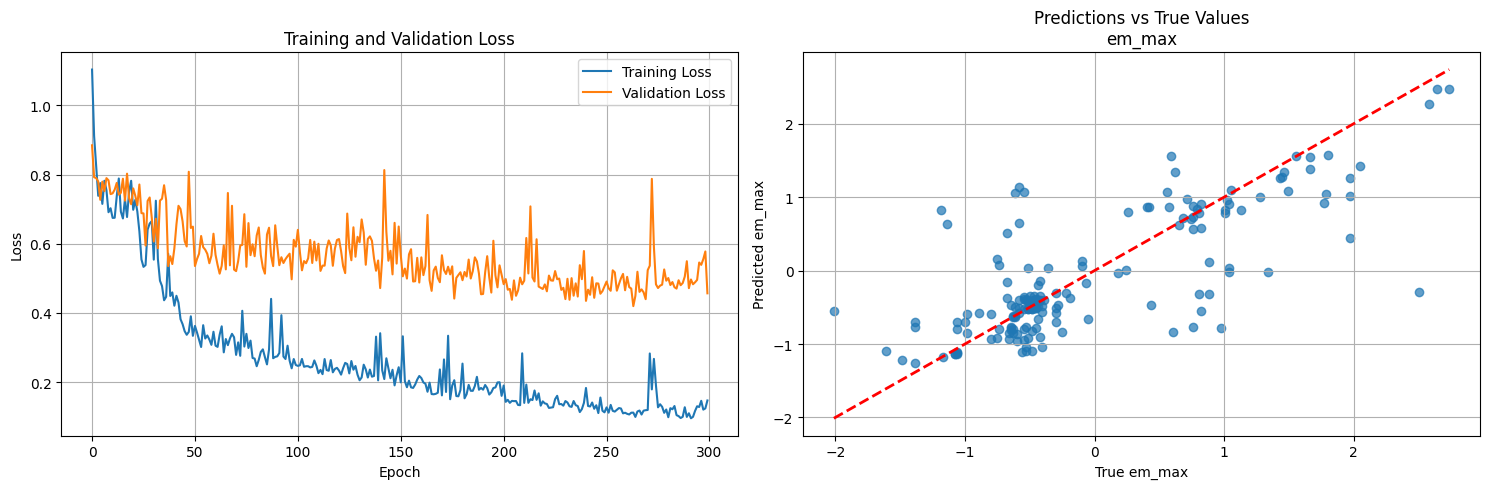


Model saved as 'lstm_model_em_max_onehot.pth'


In [ ]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  # Change this to predict different properties

# Available properties from your dataset:
# brightness, ex_max, em_max, ext_coeff, lifetime, maturation, pka, stokes_shift, qy, agg, switch_type

# Hyperparameters
MAX_LENGTH = 256
BATCH_SIZE = 64
NUM_EPOCHS = 300
LEARNING_RATE = 0.001

# sample_batch = next(iter(train_loader))[0]
# embedding_dim = sample_batch.shape[-1]


# Instantiate the new model
# выбор между EmbeddingLSTM и ProteinLSTM
model = SequenceLSTM(
    hidden_dim=256,
    num_layers=1,
    output_dim=1,
    dropout=0.3,
    bidirectional=True
)

# Train the model
print(train_loader.dataset.tensors)
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model 
torch.save(trained_model.state_dict(), f'lstm_model_{TARGET_PROPERTY}_onehot.pth')
print(f"\nModel saved as 'lstm_model_{TARGET_PROPERTY}_onehot.pth'")


<h3>Работа с EmbeddingLSTM</h3>

In [20]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  # Change this to predict different properties

# Available properties from your dataset:
# brightness, ex_max, em_max, ext_coeff, lifetime, maturation, pka, stokes_shift, qy, agg, switch_type

# Hyperparameters
MAX_LENGTH = 238
NUM_EPOCHS = 300
LEARNING_RATE = 0.001

sample_batch = next(iter(train_loader))[0]
embedding_dim = sample_batch.shape[-1]

# Instantiate the new model
# выбор между EmbeddingLSTM и ProteinLSTM
model = EmbeddingLSTM(
    embed_dim=embedding_dim,
    hidden_size=128,
    num_layers=2,
    dropout_rate=0.1
).to(device)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model
torch.save(trained_model.state_dict(), f'weights/lstm_model_{TARGET_PROPERTY}_embeddings.pth')
print(f"\nModel saved as 'lstm_model_{TARGET_PROPERTY}_embeddings.pth'")


Training on cuda
Number of parameters: 694,593


Epoch 5/300: 100%|██████████| 17/17 [00:00<00:00, 84.05it/s]


Epoch 5/300
Train Loss: 0.8628, Val Loss: 0.5711
Learning Rate: 0.001000
--------------------------------------------------


Epoch 10/300: 100%|██████████| 17/17 [00:00<00:00, 84.33it/s]


Epoch 10/300
Train Loss: 0.7716, Val Loss: 0.5432
Learning Rate: 0.001000
--------------------------------------------------


Epoch 15/300: 100%|██████████| 17/17 [00:00<00:00, 86.98it/s]


Epoch 15/300
Train Loss: 0.6960, Val Loss: 0.5436
Learning Rate: 0.001000
--------------------------------------------------


Epoch 20/300: 100%|██████████| 17/17 [00:00<00:00, 85.79it/s]


Epoch 20/300
Train Loss: 0.7680, Val Loss: 0.5494
Learning Rate: 0.001000
--------------------------------------------------


Epoch 25/300: 100%|██████████| 17/17 [00:00<00:00, 84.85it/s]


Epoch 25/300
Train Loss: 0.7076, Val Loss: 0.5543
Learning Rate: 0.001000
--------------------------------------------------


Epoch 30/300: 100%|██████████| 17/17 [00:00<00:00, 87.16it/s]


Epoch 30/300
Train Loss: 0.6941, Val Loss: 0.5468
Learning Rate: 0.001000
--------------------------------------------------


Epoch 32/300:  12%|█▏        | 2/17 [00:00<00:00, 51.28it/s]


KeyboardInterrupt: 

### Работа с EmbeddingCNN

Training on cuda
Number of parameters: 818,529


Epoch 5/200: 100%|██████████| 17/17 [00:00<00:00, 19.57it/s]


Epoch 5/200
Train Loss: 0.3467, Val Loss: 0.3784
Learning Rate: 0.000100
--------------------------------------------------


Epoch 10/200: 100%|██████████| 17/17 [00:01<00:00, 14.84it/s]


Epoch 10/200
Train Loss: 0.4081, Val Loss: 0.2627
Learning Rate: 0.000100
--------------------------------------------------


Epoch 15/200: 100%|██████████| 17/17 [00:01<00:00, 14.18it/s]


Epoch 15/200
Train Loss: 0.2521, Val Loss: 0.5339
Learning Rate: 0.000100
--------------------------------------------------


Epoch 20/200: 100%|██████████| 17/17 [00:00<00:00, 19.71it/s]


Epoch 20/200
Train Loss: 0.2404, Val Loss: 0.2352
Learning Rate: 0.000100
--------------------------------------------------


Epoch 25/200: 100%|██████████| 17/17 [00:00<00:00, 19.22it/s]


Epoch 25/200
Train Loss: 0.1867, Val Loss: 0.2713
Learning Rate: 0.000100
--------------------------------------------------


Epoch 30/200: 100%|██████████| 17/17 [00:00<00:00, 21.50it/s]


Epoch 30/200
Train Loss: 0.1771, Val Loss: 0.2532
Learning Rate: 0.000100
--------------------------------------------------


Epoch 35/200: 100%|██████████| 17/17 [00:00<00:00, 21.45it/s]


Epoch 35/200
Train Loss: 0.2237, Val Loss: 0.5059
Learning Rate: 0.000100
--------------------------------------------------


Epoch 40/200: 100%|██████████| 17/17 [00:00<00:00, 21.57it/s]


Epoch 40/200
Train Loss: 0.1608, Val Loss: 0.3561
Learning Rate: 0.000100
--------------------------------------------------


Epoch 45/200: 100%|██████████| 17/17 [00:00<00:00, 19.73it/s]


Epoch 45/200
Train Loss: 0.1239, Val Loss: 0.3135
Learning Rate: 0.000100
--------------------------------------------------


Epoch 50/200: 100%|██████████| 17/17 [00:00<00:00, 20.18it/s]


Epoch 50/200
Train Loss: 0.1748, Val Loss: 0.3614
Learning Rate: 0.000100
--------------------------------------------------


Epoch 55/200: 100%|██████████| 17/17 [00:00<00:00, 20.09it/s]


Epoch 55/200
Train Loss: 0.2261, Val Loss: 0.4703
Learning Rate: 0.000100
--------------------------------------------------


Epoch 60/200: 100%|██████████| 17/17 [00:00<00:00, 21.40it/s]


Epoch 60/200
Train Loss: 0.0970, Val Loss: 0.4425
Learning Rate: 0.000100
--------------------------------------------------


Epoch 65/200: 100%|██████████| 17/17 [00:00<00:00, 21.48it/s]


Epoch 65/200
Train Loss: 0.1035, Val Loss: 0.3391
Learning Rate: 0.000100
--------------------------------------------------


Epoch 70/200: 100%|██████████| 17/17 [00:00<00:00, 21.68it/s]


Epoch 70/200
Train Loss: 0.1222, Val Loss: 0.2746
Learning Rate: 0.000100
--------------------------------------------------


Epoch 75/200: 100%|██████████| 17/17 [00:00<00:00, 17.79it/s]


Epoch 75/200
Train Loss: 0.0726, Val Loss: 0.2450
Learning Rate: 0.000100
--------------------------------------------------


Epoch 80/200: 100%|██████████| 17/17 [00:01<00:00, 16.77it/s]


Epoch 80/200
Train Loss: 0.0777, Val Loss: 0.2781
Learning Rate: 0.000100
--------------------------------------------------


Epoch 85/200: 100%|██████████| 17/17 [00:00<00:00, 18.02it/s]


Epoch 85/200
Train Loss: 0.0979, Val Loss: 0.4626
Learning Rate: 0.000100
--------------------------------------------------


Epoch 90/200: 100%|██████████| 17/17 [00:01<00:00, 16.92it/s]


Epoch 90/200
Train Loss: 0.0701, Val Loss: 0.2344
Learning Rate: 0.000100
--------------------------------------------------


Epoch 95/200: 100%|██████████| 17/17 [00:00<00:00, 17.26it/s]


Epoch 95/200
Train Loss: 0.1870, Val Loss: 0.2983
Learning Rate: 0.000100
--------------------------------------------------


Epoch 100/200: 100%|██████████| 17/17 [00:00<00:00, 17.58it/s]


Epoch 100/200
Train Loss: 0.0825, Val Loss: 0.2435
Learning Rate: 0.000100
--------------------------------------------------


Epoch 105/200: 100%|██████████| 17/17 [00:00<00:00, 17.91it/s]


Epoch 105/200
Train Loss: 0.0909, Val Loss: 0.4314
Learning Rate: 0.000100
--------------------------------------------------


Epoch 110/200: 100%|██████████| 17/17 [00:01<00:00, 16.71it/s]


Epoch 110/200
Train Loss: 0.0903, Val Loss: 0.4678
Learning Rate: 0.000100
--------------------------------------------------


Epoch 115/200: 100%|██████████| 17/17 [00:00<00:00, 17.10it/s]


Epoch 115/200
Train Loss: 0.1303, Val Loss: 0.5660
Learning Rate: 0.000100
--------------------------------------------------


Epoch 120/200: 100%|██████████| 17/17 [00:01<00:00, 16.96it/s]


Epoch 120/200
Train Loss: 0.0650, Val Loss: 0.2565
Learning Rate: 0.000100
--------------------------------------------------


Epoch 125/200: 100%|██████████| 17/17 [00:00<00:00, 19.16it/s]


Epoch 125/200
Train Loss: 0.0494, Val Loss: 0.3103
Learning Rate: 0.000100
--------------------------------------------------


Epoch 130/200: 100%|██████████| 17/17 [00:00<00:00, 19.26it/s]


Epoch 130/200
Train Loss: 0.0561, Val Loss: 0.2460
Learning Rate: 0.000100
--------------------------------------------------


Epoch 135/200: 100%|██████████| 17/17 [00:00<00:00, 18.90it/s]


Epoch 135/200
Train Loss: 0.0729, Val Loss: 0.3651
Learning Rate: 0.000100
--------------------------------------------------


Epoch 140/200: 100%|██████████| 17/17 [00:00<00:00, 20.87it/s]


Epoch 140/200
Train Loss: 0.0552, Val Loss: 0.4113
Learning Rate: 0.000100
--------------------------------------------------


Epoch 145/200: 100%|██████████| 17/17 [00:00<00:00, 20.08it/s]


Epoch 145/200
Train Loss: 0.0640, Val Loss: 0.5945
Learning Rate: 0.000100
--------------------------------------------------


Epoch 150/200: 100%|██████████| 17/17 [00:00<00:00, 19.97it/s]


Epoch 150/200
Train Loss: 0.0754, Val Loss: 0.2436
Learning Rate: 0.000100
--------------------------------------------------


Epoch 155/200: 100%|██████████| 17/17 [00:00<00:00, 19.94it/s]


Epoch 155/200
Train Loss: 0.0499, Val Loss: 0.3859
Learning Rate: 0.000100
--------------------------------------------------


Epoch 160/200: 100%|██████████| 17/17 [00:00<00:00, 18.38it/s]


Epoch 160/200
Train Loss: 0.0478, Val Loss: 0.2165
Learning Rate: 0.000100
--------------------------------------------------


Epoch 165/200: 100%|██████████| 17/17 [00:00<00:00, 20.02it/s]


Epoch 165/200
Train Loss: 0.0485, Val Loss: 0.2769
Learning Rate: 0.000100
--------------------------------------------------


Epoch 170/200: 100%|██████████| 17/17 [00:00<00:00, 18.95it/s]


Epoch 170/200
Train Loss: 0.0665, Val Loss: 0.2452
Learning Rate: 0.000100
--------------------------------------------------


Epoch 175/200: 100%|██████████| 17/17 [00:00<00:00, 18.38it/s]


Epoch 175/200
Train Loss: 0.0469, Val Loss: 0.3785
Learning Rate: 0.000100
--------------------------------------------------


Epoch 180/200: 100%|██████████| 17/17 [00:00<00:00, 20.06it/s]


Epoch 180/200
Train Loss: 0.0800, Val Loss: 0.2578
Learning Rate: 0.000100
--------------------------------------------------


Epoch 185/200: 100%|██████████| 17/17 [00:00<00:00, 20.02it/s]


Epoch 185/200
Train Loss: 0.0473, Val Loss: 0.3177
Learning Rate: 0.000100
--------------------------------------------------


Epoch 190/200: 100%|██████████| 17/17 [00:00<00:00, 17.52it/s]


Epoch 190/200
Train Loss: 0.0455, Val Loss: 0.2446
Learning Rate: 0.000100
--------------------------------------------------


Epoch 195/200: 100%|██████████| 17/17 [00:00<00:00, 18.65it/s]


Epoch 195/200
Train Loss: 0.0759, Val Loss: 0.2751
Learning Rate: 0.000100
--------------------------------------------------


Epoch 200/200: 100%|██████████| 17/17 [00:00<00:00, 21.97it/s]


Epoch 200/200
Train Loss: 0.0662, Val Loss: 0.2497
Learning Rate: 0.000100
--------------------------------------------------

Test MSE: 0.2797
Test MAE: 0.3534
Test R²:  0.6875


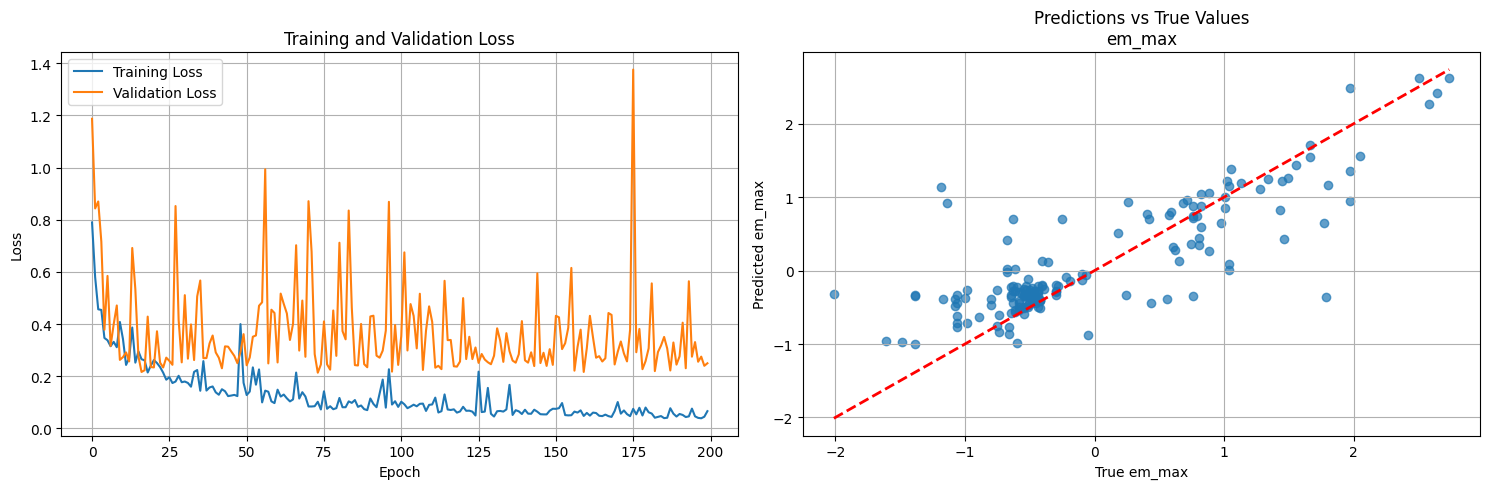

In [ ]:
TARGET_PROPERTY = 'em_max'

BATCH_SIZE = 64
NUM_EPOCHS = 200
LEARNING_RATE = 0.0001

model = EmbeddingCNN().to(device)

trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

predictions, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

plot_results(train_losses, val_losses, predictions, true_values, TARGET_PROPERTY)

torch.save(trained_model.state_dict(), f'weights/cnn_model_{TARGET_PROPERTY}_custom.pth')
# print(f"Модель сохранена как 'cnn_model_{TARGET_PROPERTY}_custom.pth'")


### Работа с SequenceCNN

In [ ]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  

MAX_LENGTH = 256
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

model = SequenceCNN(
    num_amino_acids=20, 
    num_filters=64,
    dropout_rate=0.6
)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model
torch.save(trained_model.state_dict(), f'weights/cnn_model_{TARGET_PROPERTY}_onehot.pth')
print(f"\nModel saved as 'cnn_model_{TARGET_PROPERTY}_onehot.pth'")

NameError: name 'ProteinCNN' is not defined

In [53]:
trained_model.eval()

predictions = []
true_values = []

with torch.no_grad():
    for sequences, targets in test_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        batch_predictions = model(sequences).squeeze()

        predictions.extend(batch_predictions.cpu().numpy())
        true_values.extend(targets.cpu().numpy())

    # Convert back to original scale
predictions = np.array(predictions)
true_values = np.array(true_values)
s_predictions = dataset.rescale_targets(predictions, TARGET_PROPERTY)
s_true_values = dataset.rescale_targets(true_values, TARGET_PROPERTY)

zv = get_regression_metrics(
    s_predictions,
    s_true_values
)
print(f'\t RMSE: {zv["rmse"]}')
print(f'\t MAE: {zv["mae"]}')
print(f'\t R2: {zv["r2"]}')
print(f'\t MAE (med.): {zv["mae_median"]}')


	 RMSE: 33.98408126831055
	 MAE: 22.705373764038086
	 R2: 0.6874958872795105
	 MAE (med.): 14.35479736328125


In [54]:
metrics_ci = bootstrap_metric_ci(
    s_predictions, s_true_values, get_regression_metrics, 
    n_bootstrap=1000, alpha=0.05, random_state=42
)

# Print results in a nice format
print("\nMetrics with 95% confidence intervals:")
print(f"RMSE: {(metrics_ci['rmse'][1] + metrics_ci['rmse'][2]) / 2:.2f} ± {(metrics_ci['rmse'][1] + metrics_ci['rmse'][2]) / 2 -metrics_ci['rmse'][1]:.2f}")
print(f"MAE: {(metrics_ci['mae'][1] + metrics_ci['mae'][2]) / 2:.2f} ± {(metrics_ci['mae'][1] + metrics_ci['mae'][2]) / 2 -metrics_ci['mae'][1]:.2f}")
print(f"R2: {(metrics_ci['r2'][1] + metrics_ci['r2'][2]) / 2:.2f} ± {(metrics_ci['r2'][1] + metrics_ci['r2'][2]) / 2 -metrics_ci['r2'][1]:.2f}")
print(f"MAE Median: {(metrics_ci['mae_median'][1] + metrics_ci['mae_median'][2]) / 2:.2f} ± {(metrics_ci['mae_median'][1] + metrics_ci['mae_median'][2]) / 2 -metrics_ci['mae_median'][1]:.2f}")


Metrics with 95% confidence intervals:
RMSE: 34.05 ± 6.29
MAE: 22.84 ± 3.80
R2: 0.67 ± 0.13
MAE Median: 15.24 ± 2.83
